#**Análise descritiva do conjunto público de redações Essay-br**

##Importação de bibliotecas

Descrição das bibliotecas para cálculos, métricas e processamento de texto do dataset.

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# bibliotecas para processamento de texto
import nltk
import spacy

## Carregamento de dados

Os datasets foram colocados por upload no ambiente de desenvolvimento, logo em sequência é feita a leitura como forma de conferência das variáveis presentes nas bases `essays-br.csv` e `prompts.csv`.

In [57]:
essays_df = pd.read_csv('essay-br.csv')
print(essays_df.head())

   prompt                                            title  \
0      21  A greve dos caminhoneiros e a malha ferroviária   
1      23                 Vossa excelência  Senador M. M.,   
2      39                        A validade do impeachment   
3      26      Podemos perceber que a sociedade brasileira   
4       4              Comenta-se que o ex-presidente Lula   

                                               essay  \
0  ['A grande importância dos caminhoneiros para ...   
1  ['O senhor e eu já estamos cientes do projeto ...   
2  ['É de conhecimento geral dos brasileiros o qu...   
3  ['Podemos perceber que a sociedade brasileira ...   
4  ['Comenta-se que o ex presidente Lula ex-presi...   

                  competence  score  
0  [160, 160, 120, 120, 120]    680  
1  [160, 160, 120, 120, 120]    680  
2  [120, 160, 160, 160, 120]    720  
3   [120, 120, 80, 120, 120]    560  
4            [0, 0, 0, 0, 0]      0  


In [58]:
prompts_df = pd.read_csv('prompts.csv')
print(prompts_df.head())

   id                                        description
0   0  ['No Carnaval de 2020, veio novamente à tona u...
1   1  ['O número de pessoas desempregadas no mundo d...
2   2  ['Ao longo dos últimos dez anos, o papel do ST...
3   3  ['Com o avanço da biotecnologia, da engenharia...
4   4  ['No início deste mês de novembro, o Supremo T...


## Análise Exploratória dos Dados (EDA)

Informações sobre o dataset `essay-br.csv`

In [61]:
print(essays_df.info())
print(essays_df.shape)
print(essays_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4570 entries, 0 to 4569
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   prompt      4570 non-null   int64 
 1   title       3886 non-null   object
 2   essay       4570 non-null   object
 3   competence  4570 non-null   object
 4   score       4570 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 178.6+ KB
None
(4570, 5)
prompt          0
title         684
essay           0
competence      0
score           0
dtype: int64


In [62]:
print(prompts_df.info())
print(prompts_df.shape)
print(prompts_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           86 non-null     int64 
 1   description  86 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.5+ KB
None
(86, 2)
id             0
description    0
dtype: int64


In [64]:
#tratamento de duplicatas
essays_df.drop_duplicates(inplace=True)
prompts_df.drop_duplicates(inplace=True)

### Distribuições das pontuações

O gráfico mostra uma distribuição assimétrica à esquerda, onde a maioria das pontuações se concentra em torno de 600 (a medida da moda). Há variações consideráveis em outros intervalos, especialmente entre 400 e 800 pontos, onde a frequência das pontuações varia mais.

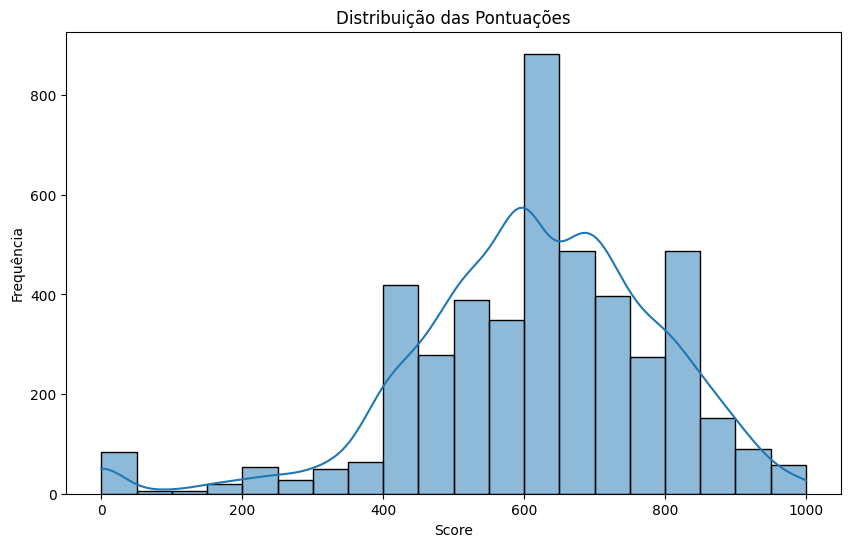

In [66]:
# gráfico das pontuações - visualizar formato da distribuição
plt.figure(figsize=(10, 6))
sns.histplot(essays_df['score'], bins=20, kde=True)
plt.title('Distribuição das Pontuações')
plt.xlabel('Score')
plt.ylabel('Frequência')
plt.show()

In [65]:
#estatísticas descritivas da distribuição
print(essays_df['score'].describe())

count    4570.000000
mean      614.030635
std       176.878132
min         0.000000
25%       520.000000
50%       600.000000
75%       720.000000
max      1000.000000
Name: score, dtype: float64


### Distribuições dos tópicos (temas)

Alguns tópicos têm uma contagem muito alta de ensaios, indicando que são temas populares entre os participantes. Por exemplo, os tópicos nos intervalos em torno de 45-55 e 80-90, com picos acima de 120 redações.

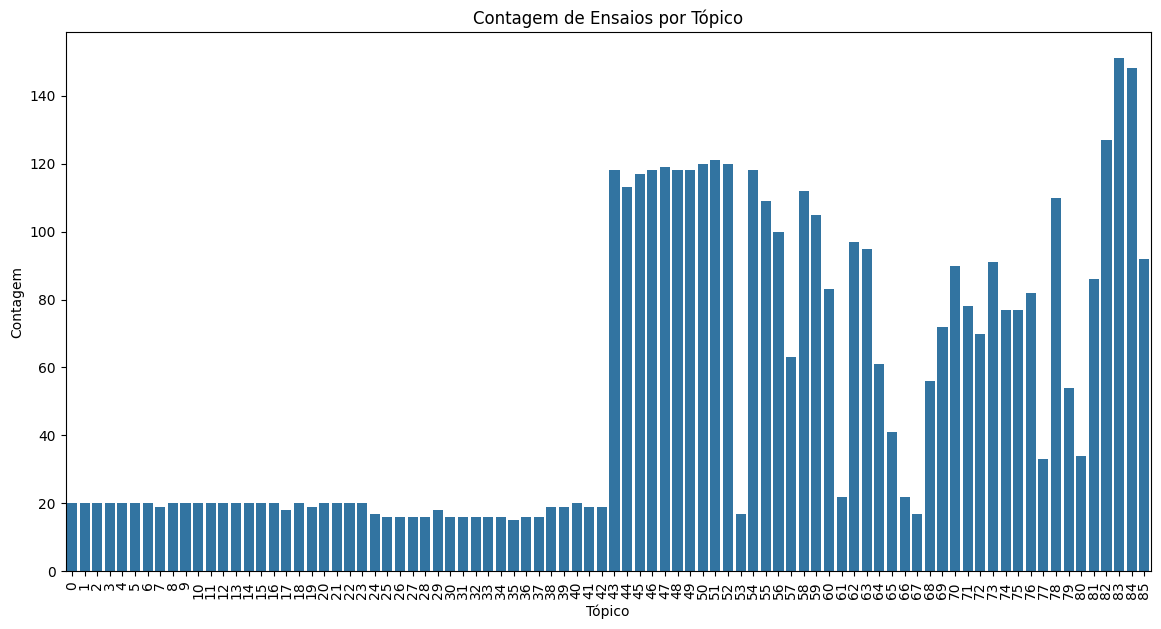

In [25]:
# Contagem de ensaios por tema de eixo
prompt_counts = essays_df['prompt'].value_counts()

plt.figure(figsize=(14, 7))
sns.barplot(x=prompt_counts.index, y=prompt_counts.values)
plt.xticks(rotation=90)
plt.title('Contagem de Ensaios por Tópico')
plt.xlabel('Tópico')
plt.ylabel('Contagem')
plt.show()

O gráfico apresenta a variação das pontuações para diferentes tópicos, com caixas representando o intervalo interquartil (IQR), linhas indicando a faixa de dados dentro de 1,5 vezes o IQR, e pontos indicando outliers. As linhas dentro das caixas representam a mediana das pontuações para cada tópico.

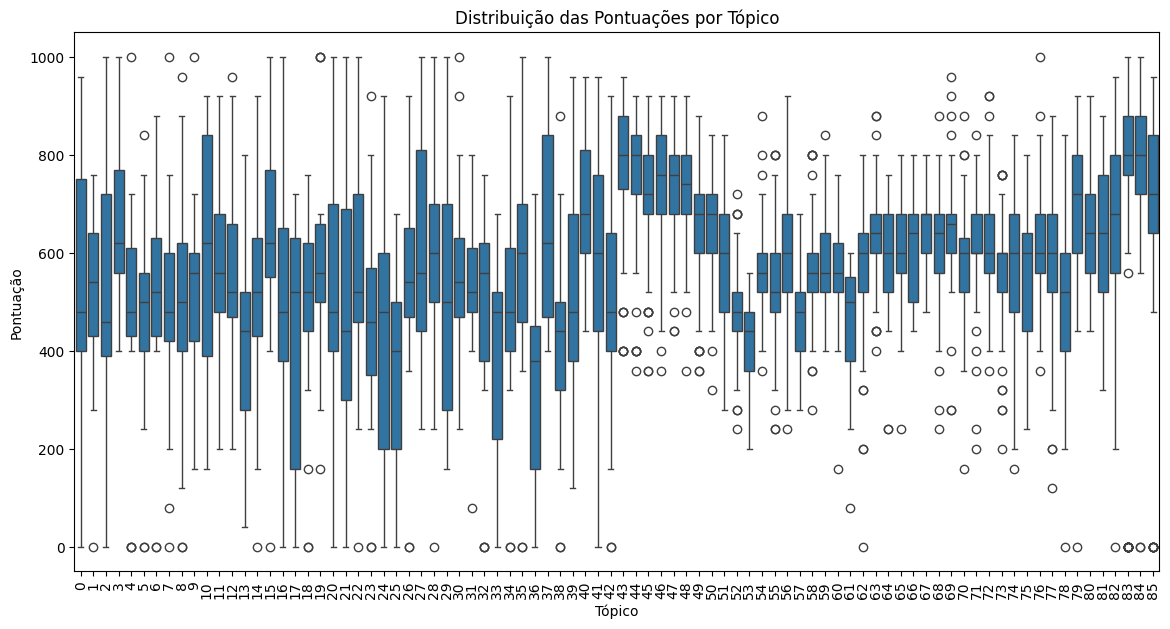

In [30]:
# Distribuição das pontuações por tema
plt.figure(figsize=(14, 7))
sns.boxplot(x='prompt', y='score', data=essays_df)
plt.xticks(rotation=90)
plt.title('Distribuição das Pontuações por Tópico')
plt.xlabel('Tópico')
plt.ylabel('Pontuação')
plt.show()

Uma possibilidade é azer uma análise qualitativa detalhada dos ensaios em tópicos populares versus impopulares para entender melhor as diferenças na qualidade e nos desafios enfrentados pelos alunos.

### Análise de texto

#### Tokenização e remoção de stop words

**Tokenização:** Processo de dividir o texto em unidades menores chamadas "tokens", que geralmente são palavras ou frases curtas. <br>
**Remoção de Stop Words:** Stop words são palavras comuns (como "a", "de", "é") que geralmente não adicionam significado significativo ao texto.

In [38]:
!pip install spacy
!python -m spacy download pt_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 30.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [40]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [67]:
nlp = spacy.load("pt_core_news_sm")
stop_words = nltk.corpus.stopwords.words('portuguese')

all_texts = essays_df['essay'].tolist()
all_tokens = []

for text in tqdm(all_texts):
  doc = nlp(text)
  tokens = [token.text.lower() for token in doc if token.is_alpha and token.text.lower() not in stop_words]
  all_tokens.extend(tokens)

100%|██████████| 4570/4570 [04:32<00:00, 16.75it/s]


#### Frequência de palavras

Refere-se ao número de vezes que cada palavra aparece em um texto ou no conjunto de textos, permitindo insights sobre os temas e tópicos predominantes. A nuvem de palavras é a representação visual a partir da frequência obtida.

In [68]:
from collections import Counter
word_freq = Counter(all_tokens)
print(word_freq.most_common(20))

[('brasil', 4419), ('pessoas', 4133), ('sociedade', 3823), ('população', 3590), ('assim', 3412), ('educação', 3009), ('saúde', 3008), ('forma', 2990), ('país', 2876), ('sobre', 2634), ('pois', 2510), ('além', 2458), ('ainda', 2402), ('meio', 2375), ('pode', 2326), ('vida', 2299), ('deve', 2255), ('sendo', 2241), ('todos', 2216), ('governo', 2189)]


#### Nuvem de palavras

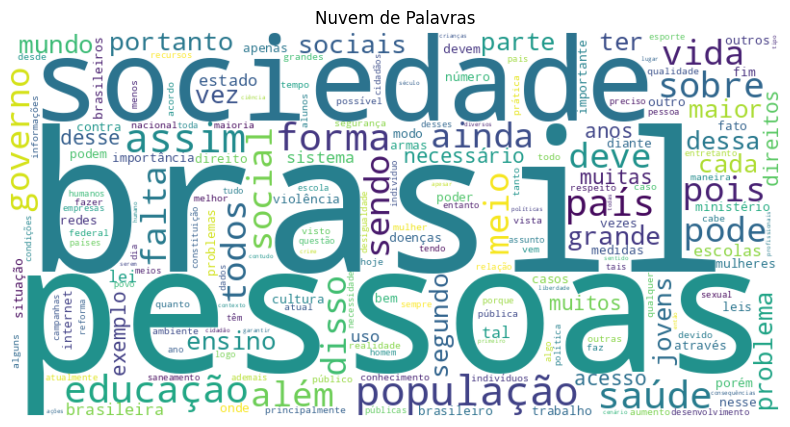

In [69]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras')
plt.show()

#### Bigramas e trigramas

 São sequências de duas ou três palavras adjacentes em um texto, para captura de contexto  e identificação de expressóes.

In [70]:
from nltk import bigrams, trigrams
bigrams_freq = Counter(bigrams(all_tokens))
trigrams_freq = Counter(trigrams(all_tokens))

print("Bigramas mais frequentes:", bigrams_freq.most_common(10))
print("Trigramas mais frequentes:", trigrams_freq.most_common(10))

Bigramas mais frequentes: [(('além', 'disso'), 1128), (('redes', 'sociais'), 974), (('dessa', 'forma'), 878), (('cada', 'vez'), 813), (('muitas', 'vezes'), 610), (('sendo', 'assim'), 525), (('desse', 'modo'), 454), (('meio', 'ambiente'), 424), (('saneamento', 'básico'), 422), (('nesse', 'sentido'), 408)]
Trigramas mais frequentes: [(('sistema', 'único', 'saúde'), 139), (('organização', 'mundial', 'saúde'), 121), (('portanto', 'medidas', 'necessárias'), 121), (('reforma', 'ensino', 'médio'), 121), (('medidas', 'necessárias', 'resolver'), 115), (('privatização', 'saneamento', 'básico'), 101), (('necessárias', 'resolver', 'impasse'), 93), (('declaração', 'universal', 'direitos'), 93), (('grande', 'parte', 'população'), 91), (('organização', 'nações', 'unidas'), 84)]


#### Modelagem de tópicos (Topic Modeling) - LDA (Latent Dirichlet Allocation)

Inicia-se importando as bibliotecas necessárias para a vetorização de texto e a decomposição de tópicos e cria-se um vetorizador que transforma os textos em uma matriz de contagem de palavras. Tem-se então um modelo LDA para encontrar 5 tópicos nos textos, com as dez palavras mais significativas.

In [75]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(all_texts)

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

for index, topic in enumerate(lda.components_):
    print(f'Tópico #{index}:')
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print('\n')

Tópico #0:
['educação', 'mais', 'da', 'um', 'uma', 'os', 'com', 'se', 'não', 'em']


Tópico #1:
['como', 'não', 'por', 'uma', 'os', 'um', 'com', 'da', 'se', 'em']


Tópico #2:
['como', 'um', 'uma', 'por', 'dos', 'os', 'com', 'se', 'em', 'da']


Tópico #3:
['não', 'por', 'os', 'com', 'saúde', 'uma', 'um', 'em', 'se', 'da']


Tópico #4:
['como', 'na', 'não', 'uma', 'por', 'os', 'com', 'se', 'em', 'da']




Existe a possibilidade dos textos no dataset serem muito similares compalavras comuns e repetitivas, isso pode afetando a qualidade dos tópicos gerados.

#### Análise de entidades nomeadas (Named Entity Recognition - NER)

Tratativa para identificar e classificar entidades em um texto em categorias predefinidas, como pessoas, organizações, locais, datas e outros tipos de entidades.

In [76]:
all_entities = []
for text in tqdm(all_texts):
  doc = nlp(text)
  entities = [(ent.text, ent.label_) for ent in doc.ents]
  all_entities.extend(entities)

entity_freq = Counter(all_entities)
print(entity_freq.most_common(20))

100%|██████████| 4570/4570 [04:27<00:00, 17.08it/s]

[(('Brasil', 'LOC'), 3953), (('Estado', 'LOC'), 846), (('Portanto', 'MISC'), 453), (('Portanto', 'LOC'), 414), (('SUS', 'ORG'), 305), (('Ministério da Educação', 'LOC'), 274), (('internet', 'MISC'), 252), (('Ministério da Saúde', 'LOC'), 244), (('Governo', 'LOC'), 242), (('Governo Federal', 'LOC'), 214), (('Amazônia', 'LOC'), 205), (('O Brasil', 'MISC'), 179), (('Estados Unidos', 'LOC'), 178), (('MEC', 'LOC'), 164), (('Constituição Federal', 'LOC'), 163), (('IBGE', 'LOC'), 159), (('Rio de Janeiro', 'LOC'), 144), (('Destarte', 'LOC'), 141), (('fake news', 'MISC'), 137), (('OMS', 'ORG'), 136)]


A saída mostra pares de (entidade, categoria) e a contagem de ocorrências dessa entidade em seu texto.

#### Análise de sentimentos

O código analisa cada texto no conjunto all_texts para determinar o sentimento (polaridade) e a subjetividade, armazenando os resultados em um DataFrame. Quanto à visualização, plota histogramas da distribuição de ambos.

100%|██████████| 4570/4570 [00:10<00:00, 433.16it/s]


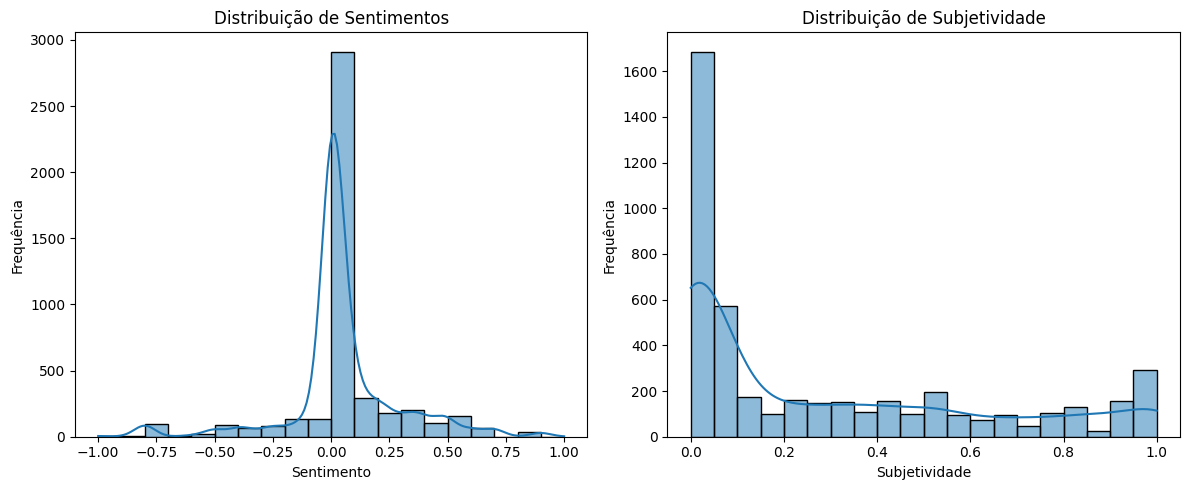

In [77]:
from textblob import TextBlob

sentiments = []
subjectivities = []
for text in tqdm(all_texts):
  blob = TextBlob(text)
  sentiments.append(blob.sentiment.polarity)
  subjectivities.append(blob.sentiment.subjectivity)

essays_df['sentiment'] = sentiments
essays_df['subjectivity'] = subjectivities

# plotagem da distribuição
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(essays_df['sentiment'], bins=20, kde=True)
plt.title('Distribuição de Sentimentos')
plt.xlabel('Sentimento')
plt.ylabel('Frequência')

plt.subplot(1, 2, 2)
sns.histplot(essays_df['subjectivity'], bins=20, kde=True)
plt.title('Distribuição de Subjetividade')
plt.xlabel('Subjetividade')
plt.ylabel('Frequência')

plt.tight_layout()
plt.show()

O eixo X no primeiro gráfico representa o valor de polaridade do sentimento, que varia de -1 (muito negativo) a +1 (muito positivo). O eixo X no segundo gráfico representa o valor de subjetividade, que varia de 0 (objetivo) a 1 (subjetivo).  O eixo Y mostra a frequência ou o número de textos que possuem tais características.

#### Análise de complexidade sintática

Objetivo de analisar como as palavras e frases estão organizadas e como isso afeta a dificuldade de compreensão e processamento do texto.

100%|██████████| 4570/4570 [04:14<00:00, 17.94it/s]


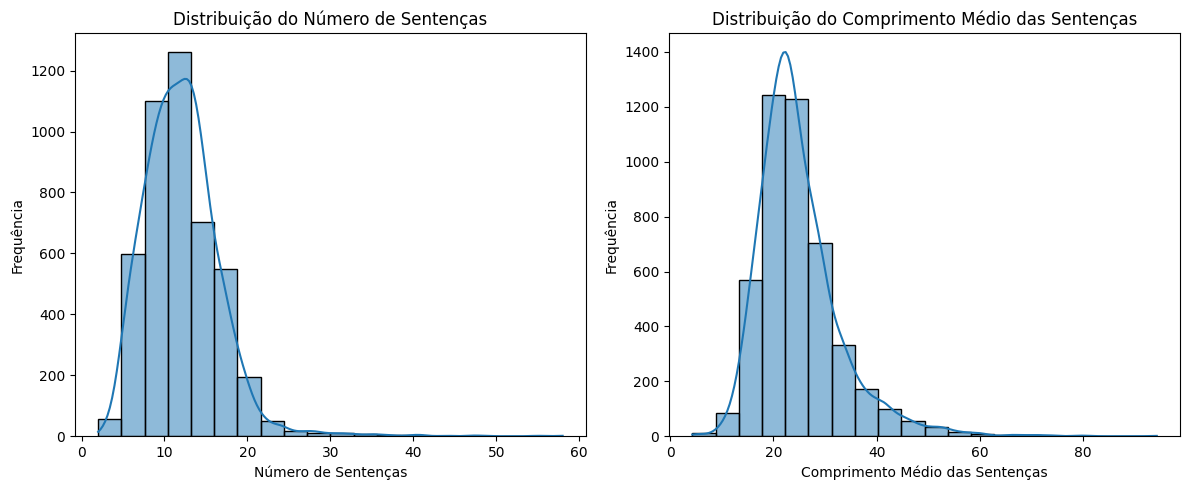

In [78]:
def analyze_syntax(text):
  doc = nlp(text)
  num_sentences = len(list(doc.sents))
  num_words = len([token for token in doc if token.is_alpha])
  avg_sentence_length = num_words / num_sentences if num_sentences > 0 else 0
  return num_sentences, avg_sentence_length

sentence_counts = []
avg_sentence_lengths = []
for text in tqdm(all_texts):
  num_sentences, avg_sentence_length = analyze_syntax(text)
  sentence_counts.append(num_sentences)
  avg_sentence_lengths.append(avg_sentence_length)

essays_df['num_sentences'] = sentence_counts
essays_df['avg_sentence_length'] = avg_sentence_lengths

# Visualização da complexidade sintática
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(essays_df['num_sentences'], bins=20, kde=True)
plt.title('Distribuição do Número de Sentenças')
plt.xlabel('Número de Sentenças')
plt.ylabel('Frequência')

plt.subplot(1, 2, 2)
sns.histplot(essays_df['avg_sentence_length'], bins=20, kde=True)
plt.title('Distribuição do Comprimento Médio das Sentenças')
plt.xlabel('Comprimento Médio das Sentenças')
plt.ylabel('Frequência')

plt.tight_layout()
plt.show()

O pico em torno de 20-30 caracteres indica que muitas sentenças têm um comprimento médio relativamente curto.

#### Análise de Correlação

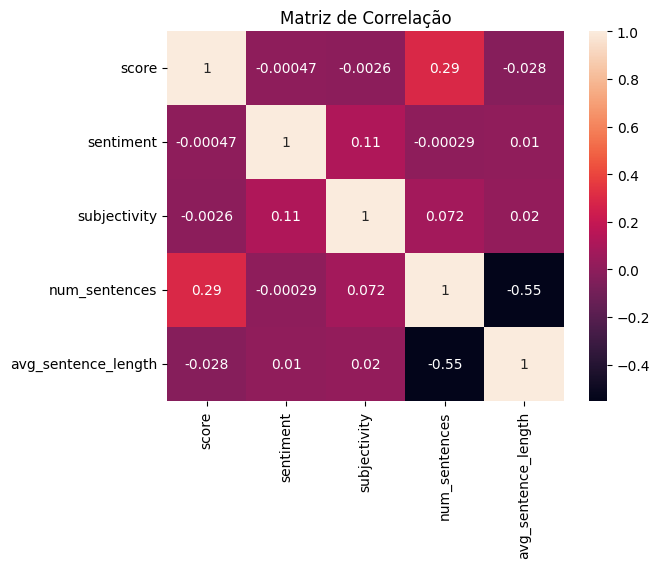

In [79]:
# matriz de correlação entre características e score
correlation_matrix = essays_df[['score', 'sentiment', 'subjectivity', 'num_sentences', 'avg_sentence_length']].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title('Matriz de Correlação')
plt.show()

In [49]:
from scipy.stats import pearsonr, spearmanr

corr_score_sentiment, p_value_score_sentiment = pearsonr(essays_df['score'], essays_df['sentiment'])
corr_score_subjectivity, p_value_score_subjectivity = pearsonr(essays_df['score'], essays_df['subjectivity'])
corr_score_num_sentences, p_value_score_num_sentences = pearsonr(essays_df['score'], essays_df['num_sentences'])
corr_score_avg_sentence_length, p_value_score_avg_sentence_length = pearsonr(essays_df['score'], essays_df['avg_sentence_length'])

print("Correlação entre pontuação e sentimento:", corr_score_sentiment, "Valor-p:", p_value_score_sentiment)
print("Correlação entre pontuação e subjetividade:", corr_score_subjectivity, "Valor-p:", p_value_score_subjectivity)
print("Correlação entre pontuação e número de sentenças:", corr_score_num_sentences, "Valor-p:", p_value_score_num_sentences)
print("Correlação entre pontuação e comprimento médio das sentenças:", corr_score_avg_sentence_length, "Valor-p:", p_value_score_avg_sentence_length)


Correlação entre pontuação e sentimento: -0.0004726532559486881 Valor-p: 0.9745171401258412
Correlação entre pontuação e subjetividade: -0.002646563440679431 Valor-p: 0.8580446815535168
Correlação entre pontuação e número de sentenças: 0.2938565233168473 Valor-p: 1.0527297947275413e-91
Correlação entre pontuação e comprimento médio das sentenças: -0.027703189796554013 Valor-p: 0.06111923652998724


### Suposições e questões

Notas sobre dúvidas para correção automática de redações

*   Considerando os critérios de correção do ENEM passam por dois avaliadores em busca de senso comum para média (com possibilidade de um terceiro), como pontuar em caso que o aluno peça revisão da nota obtida?

*   Possibilidade de identificação de cópia do texto (podendo ser dos colocados como referência ou de outra parte da prova)?

*    Identificação de atendimento ao tipo textual argumentativo?

*    Como lidar com ambiguidades e subjetividade na composição do texto?

*    Como tratar erros gramaticais e de coesão para definição da pontuação (a nível de competência e soma total dos critérios)?

*    Possibilidade de feedback para o aluno a partir de comparação com os critérios de avaliação






###Plano de solução

**Etapas:**


1.   **Definição de Requisitos:** definição de critérios de avaliação trazidos pela cartilha de correção do ENEM e escala de notas. Além de identificação do tipo argumentativo como validação.
2.   **Coleta de dados:** banco de redações corrigidas por avaliadores humanos, com notas atribuídas para treinamento dos modelos. Dar atenção para garantia de diversidade de temas.
3.   **Pré-processamento:** para o tratamento dos dados com identificação de valores faltantes, remoção de ruídos, tokenização, remoção de stopwords, extração de características como contagem de palavras e estrutura de parágrafos.
4.   **Stack tecnológica:** uso da linguagem de programção Python,por bibliotecas de Processamento de Linguagem Natural e aprendizado de máquina - como NLTK, spaCy, scikit-learn, TensorFlow, Pytorch. Como ferramentas de análise semântica pode-se utilizar Word2Vec ou Glove para representação em formato vetorial e o BERT para compreensão de contexto. Para o desenvolvimento, tem-se o Jupyter Notebook e o Google Colab, esse último com suporte a GPUs;
5.   **Técnicas e Algoritmos:** Para a extração de características sintáticas e semânticas pode-se utilizar n-grams, TF-IDF(Term Frequency-Inverse Document Frequency). Então, os modelos de avaliação como regressão linear ou logística para modelagem inicial, random forest e gradient boosting para classificação e regressão, redes neurais convolucionais (CNN) e recorrentes (RNN) para entendimento de dependências contextuais e sequenciais. Para análise de mais complexas, o uso de transformers como o modelo BERT.
6.   **Validação e Teste:** validação cruzada (K-fold) para observação de desempenho do modelo e métricas de avaliação como MSE (Mean Squared Error), RMSE (Root Mean Squared Error), precisão, recall, F1-score, etc.














### Referências Bibliográficas

BRASIL. Instituto Nacional de Estudos e Pesquisas Educacionais Anísio Teixeira (Inep). A Redação do Enem 2023: cartilha do participante. Brasília, 2023.

MARINHO, Jeziel C.; ANCHIÊTA, Rafael T.; MOURA, Raimundo S.. Essay-BR: a Brazilian Corpus of Essays. In: DATASET SHOWCASE WORKSHOP (DSW), 3. , 2021, Rio de Janeiro. Anais [...]. Porto Alegre: Sociedade Brasileira de Computação, 2021 . p. 53-64. DOI: https://doi.org/10.5753/dsw.2021.17414.

RASSI, Amanda Pontes; DE ABREU LOPES, Priscilla. Capítulo 19: Correção automática de redação. 2023.

